In [1]:
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty
from astropy.io import fits
from datetime import date
from pandas import to_datetime
import pandas as pd
#from scripts.ingests.utils import * #scripts do not need anything from ingest
import numpy.ma as ma
from astropy.table import Table #need to import astropy.table to get Table to work
import os #need to import to connect to the computer operating system , I think this is used to find and relocate files
import astropy.units as u #need to import units to use 

In [2]:
#import logging
#logger = logging.getLogger('')
#logger.setLevel(logging.DEBUG)


In [3]:
# Read in CSV file as Astropy table
table_file = 'Manja19_spectra - Sheet1.csv'
data = Table.read(table_file)

#accesses a data table
#print(data.more() )#to view data table but does not work 

In [4]:
#pd.set_option('display.max_rows', None)
#df = pd.read_csv('Manja19_spectra - Sheet1.csv')
#print(df)
#to view the table before I understood how to look at file in astropy

In [5]:

original_data_dir = 'HST_library_Manjavacas2019/' #got rid of temp_data at begining of directory
fits_data_dir = 'Manj19/'
#this is where the original data is located and I creaeted a new folder for where to put the converted fits files
#Do we start automatically in SIMPLE-db-main bc this is where the notebook is located?

for row in data:
    object = row['Source'] #row is defined so it loops through each row to 
    #logger.debug(f'source: {object}')

    spectrum_url = row['Spectrum'] #goes to specific column entry finds the url 

    file = os.path.basename(spectrum_url) #returns basename of pathname to be used in next line to read each spectrum which is a .csv file
    spectrum_table = Table.read(original_data_dir + file, format='ascii') #makes a table of spectrum to read the file in the format of ascii and uses directory to find it
    #logger.debug(f"{spectrum_url} \n {file}")
    #so these lines of code find the 
    
    obs_date = to_datetime(row['observation_date']) #locates observation date using pds 
    #logger.debug(f'obs date: {obs_date}')

    instrument = row['instrument'] 
    telescope = row['telescope']
    author = 'Manjavacas et al 2019, AJ, 157, 101'
    reference_doi = '10.3847/1538-3881/aaf88f'
    comment = row['spectrum comments']

    history1 = f'Original file: {file}' #gives orginal .csv name of file
    history2 = 'This file generated by SIMPLE-db/scripts/ingests/rewrite_spectra.py' #shows where file came from 

    wavelength_unit = u.micron  #using astropy to defien units 
    flux_unit = u.erg/u.cm/u.cm/u.s/u.Angstrom

    wavelength = spectrum_table['col1'] * wavelength_unit   #multiplying everythign by untis to convert
    flux = spectrum_table['col2'] * flux_unit
    flux_unc_class = StdDevUncertainty(spectrum_table['col3'])  #not sure waht this line does
    flux_unc = spectrum_table['col3'] * flux_unit  #gives arrays of flux w units 

    spectrum_data_out = Table({'wavelength': wavelength, 'flux':flux, 'flux_uncertainty':flux_unc}) 
    #creates a table w wavelenght, flux, and flux uncertainty

    hdu1 = fits.BinTableHDU(data = spectrum_data_out) #idk what this does
    hdu1.header['EXTNAME'] = 'SPECTRUM' #prints out different headers
    # spectrum = Spectrum1D(spectral_axis=wavelength, flux=flux, uncertainty=flux_unc)

    # Build the header
    header = fits.Header()
    header.set('EXTNAME', 'PRIMARY', 'name of this extension')
    # IVOA SpectrumDM keywords REQUIRED
    header.set('VOCLASS', 'Spectrum-1.0')
    header.set('VOPUB', 'NOT SURE WHAT THIS SHOULD BE')
    header.set('TITLE', 'NOT SURE WHAT THIS SHOLUD BE')
    header.set('OBJECT', object, 'name of observed object')
    header.set('RA', 'RA')
    header.set('DEC', 'dec')
    header.set('TMID', 'time')
    header.set('TELAPSE', 'exposure time')
    header.set('SPEC_VAL', 'bandpass')
    header.set('SPEC_BW', 'bandwidth')
    header.set('TDMIN1', min(wavelength).value)
    header.set('TDMAX1', max(wavelength).value)
    # Other IVOA SpectrumDM keywords
    header.set('AUTHOR', 'NOT SURE WHAT THIS SHOLUD BE' )
    header.set('DATE', date.today().strftime("%Y-%m-%d"), 'date of file creation')
    header.set('INSTRUME', instrument, 'name of instrument')
    header.set('DATE-OBS', obs_date.strftime("%Y-%m-%d"), 'date of the observation')
    header.set('AUTHOR', author, 'author of the data')
    header.set('REFERENC', reference_doi, 'bibliographic reference')
    header.set('TELESCOP', telescope, 'name of telescope')
    if not ma.is_masked(comment):
        header.set('COMMENT', comment)
    header.set('HISTORY', history1)
    header.set('HISTORY', history2)
    
    # Associate the header with the spectrum meta
    hdu0 = fits.PrimaryHDU(header=header) #not sure what this menas 

    spectrum_mef = fits.HDUList([hdu0,hdu1])

    file_root = os.path.splitext(file)[0] #split the path name into a pair root and ext so the root is just the ext [0] is the name of the file wihtout the .csv
    fits_filename = fits_data_dir + file_root + '.fits' #turns into fits files by putting it in new folder that we defined at begining and adding name of file then .fits
    try:
        spectrum_mef.writeto(fits_filename, overwrite=True)
        # SHOULD BE: spectrum.write(fits_filename, format='tabular-fits', overwrite=True, update_header=True)
        #logger.info(f'Wrote {fits_filename}')
    except:
        raise SimpleError

# Read the spectrum back in and check
spec1d_fits_rt = fits.open(fits_filename)
header_rt = spec1d_fits_rt[0].header
spec1d_rt = Spectrum1D.read(fits_filename) #reads the fits file



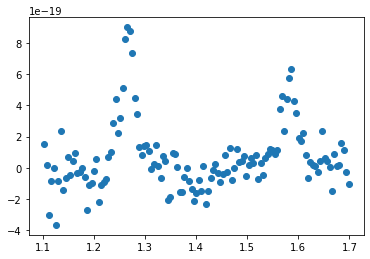

In [8]:
import numpy as np
import matplotlib.pyplot as plt
wavelength, flux = np.empty(0), np.empty(0)
for x in spectrum_table['col1']:
    wavelength = np.append(wavelength, x)
    
for x in spectrum_table['col2']:
    flux = np.append(flux, x)
    
plt.scatter(wavelength, flux)
plt.show()

Filename: Manj19/CFBDSIR2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  SPECTRUM      1 BinTableHDU     18   500R x 3C   [D, D, D]   


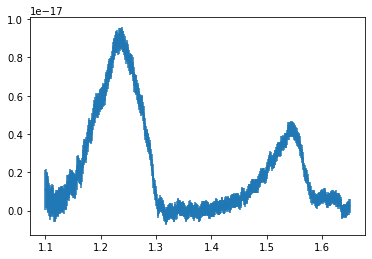

In [9]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

image_file = get_pkg_data_filename('Manj19/CFBDSIR2.fits')
#fits.info(image_file)
hdul = fits.open(image_file)

hdul.info()
spectrum = hdul[1].data['wavelength']
plt.errorbar(hdul[1].data['wavelength'],hdul[1].data['flux'],hdul[1].data['flux_uncertainty'])


print(hdul[0])
plt.show()